In [2]:
import os
import time
import pickle
import numpy as np
import matplotlib, matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import torch
import itertools
from torch.autograd import Variable
import sklearn, sklearn.model_selection, sklearn.metrics
import numpy as np

from models.model_wrapper import MLP, GCN, SLR
from data import datasets
from data.gene_graphs import GeneManiaGraph
from data.utils import record_result



In [3]:
dataset = datasets.TCGADataset()
dataset.df = dataset.df - dataset.df.mean(axis=0)

Torrent name: TCGA_tissue_ppi.hdf5, Size: 1748.32MB
Checking for pieces on disk: |██████████████████████████████████████████████████| 100.0% 
Found 1668 finished pieces out of 1668 total pieces.
Converting one-hot labels to integers


In [15]:
# Setup the results dictionary
filename = "experiments/results/fig-5.pkl"
try:
    results = pickle.load(open(filename, "rb"), encoding='latin1')
    print("Loaded Checkpointed Results")
except Exception as e:
    results = pd.DataFrame(columns=['auc', 'gene', 'model', 'num_genes', 'seed', 'train_size', 'time_elapsed'])
    print("Created a New Results Dictionary")


Loaded Checkpointed Results


In [5]:
gene_graph = GeneManiaGraph()

Torrent name: genemania.pkl, Size: 9.61MB
Checking for pieces on disk: |██████████████████████████████████████████████████| 100.0% 
Found 294 finished pieces out of 294 total pieces.


In [20]:
search_num_genes=[50, 100, 200, 300, 500, 1000, 2000, 4000]#, 8000]
test_size=1000
search_train_size=[50]
cuda=True
trials=5
search_genes = ["RPL4", "IL5", "CEBPD", "RPL5", "RPS10", "RPS3",  "PABPC3", "PSMB10", "S100A8", "S100A9", "TOP1", "C15orf40", "RNF138", "DLGAP2", "EVI2B", "ZFP82", "MYBL2", "PSMB1", "CISD1", "HLA-B", "SAA2", "IFIT1", "RPS3A", "TP53", "TNF", "EGFR"]
model_list = [           
              GCN(name="GCN_lay20_chan32_emb32_dropout_pool_hierarchy", cuda=cuda, num_layer=4, channels=32, embedding=32, prepool_extralayers=5, pooling="hierarchy"),
              GCN(name="GCN_lay20_chan32_emb32_dropout_pool_random", cuda=cuda, num_layer=4, channels=32, embedding=32, prepool_extralayers=5, pooling="random"),
#               GCN(name="GCN_lay3_chan64_emb32_pool_hierarchy", cuda=cuda, dropout=True, num_layer=3, channels=64, embedding=32, pooling="hierarchy"),
#               GCN(name="GCN_lay3_chan64_emb32_pool_random", cuda=cuda, dropout=True, num_layer=3, channels=64, embedding=32, pooling="random"),
              MLP(name="MLP_lay2_chan512_dropout", cuda=cuda, dropout=True, num_layer=2, channels=512),
              MLP(name="MLP_lay2_chan512", cuda=cuda, dropout=False, num_layer=2, channels=512),
              SLR(name="SLR_lambda1_l11", cuda=cuda)
             ]

In [21]:
# Create the set of all experiment ids and see which are left to do
model_names = [model.name for model in model_list]
columns = ["gene", "model", "num_genes", "train_size", "seed"]
all_exp_ids = [x for x in itertools.product(search_genes, model_names, search_num_genes, search_train_size, range(trials))]
all_exp_ids = pd.DataFrame(all_exp_ids, columns=columns)
all_exp_ids.index = ["-".join(map(str, tup[1:])) for tup in all_exp_ids.itertuples(name=None)]
results_exp_ids = results[columns].copy()
results_exp_ids.index = ["-".join(map(str, tup[1:])) for tup in results_exp_ids.itertuples(name=None)]
intersection_ids = all_exp_ids.index.intersection(results_exp_ids.index)
todo = all_exp_ids.drop(intersection_ids).to_dict(orient="records")
print("todo: " + str(len(todo)))
print("done: " + str(len(results)))

todo: 4760
done: 608


In [22]:
def get_every_n(a, n=2):
    for i in range(a.shape[0] // 2):
        yield a[2*i:2*(i+1)]


In [23]:
for row in todo:
    print(row)
    start_time = time.time()
    gene = row["gene"]
    model_name = row["model"]
    seed = row["seed"]
    num_genes = row["num_genes"]
    train_size = row["train_size"]

    model = [x for x in model_list if x.name == model_name][0]

    experiment = {
        "gene": gene,
        "model": model.name,
        "num_genes": num_genes,
        "train_size": train_size,
        "seed": seed,
    }

    dataset.labels = dataset.df[gene].where(dataset.df[gene] > 0).notnull().astype("int")
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dataset.df, dataset.labels, stratify=dataset.labels, train_size=train_size, test_size=test_size, random_state=seed)

    neighbors = gene_graph.bfs_sample_neighbors(gene, num_genes)

    X_train = X_train[list(neighbors.nodes)].copy()
    X_test = X_test[list(neighbors.nodes)].copy()
    X_train[gene] = 1
    X_test[gene] = 1
    adj = np.asarray(nx.to_numpy_matrix(neighbors))
    model.fit(X_train, y_train, adj=adj)
    
    x_test = Variable(torch.FloatTensor(np.expand_dims(X_test.values, axis=2)), requires_grad=False).float()
    if cuda:
        x_test = x_test.cuda()
    
    y_hat = []
    for chunk in get_every_n(x_test, 10):
        y_hat.extend(model.predict(chunk)[:,1].data.cpu().numpy().tolist())
    auc = sklearn.metrics.roc_auc_score(y_test, np.asarray(y_hat).flatten())

    del model
    experiment["auc"] = auc
    experiment["time_elapsed"] = str(time.time() - start_time)
    results = record_result(results, experiment, filename)
    print("time elapsed for genes: " +str(num_genes) + " : " + str(time.time() - start_time))


{'seed': 0, 'gene': 'CEBPD', 'num_genes': 50, 'model': 'GCN_lay20_chan32_emb32_dropout_pool_random', 'train_size': 50}
time elapsed for genes: 50 : 4.6004297733306885
{'seed': 1, 'gene': 'CEBPD', 'num_genes': 50, 'model': 'GCN_lay20_chan32_emb32_dropout_pool_random', 'train_size': 50}
time elapsed for genes: 50 : 2.213397979736328
{'seed': 2, 'gene': 'CEBPD', 'num_genes': 50, 'model': 'GCN_lay20_chan32_emb32_dropout_pool_random', 'train_size': 50}
time elapsed for genes: 50 : 2.114988327026367
{'seed': 3, 'gene': 'CEBPD', 'num_genes': 50, 'model': 'GCN_lay20_chan32_emb32_dropout_pool_random', 'train_size': 50}
time elapsed for genes: 50 : 2.159252643585205
{'seed': 4, 'gene': 'CEBPD', 'num_genes': 50, 'model': 'GCN_lay20_chan32_emb32_dropout_pool_random', 'train_size': 50}
time elapsed for genes: 50 : 2.377046823501587
{'seed': 0, 'gene': 'CEBPD', 'num_genes': 100, 'model': 'GCN_lay20_chan32_emb32_dropout_pool_random', 'train_size': 50}
time elapsed for genes: 100 : 2.189876079559326
{

KeyboardInterrupt: 

In [24]:
results.gene

0      RPL4
1      RPL4
2      RPL4
3      RPL4
4      RPL4
5      RPL4
6      RPL4
7      RPL4
8      RPL4
9      RPL4
10     RPL4
11     RPL4
12     RPL4
13     RPL4
14     RPL4
15     RPL4
16     RPL4
17     RPL4
18     RPL4
19     RPL4
20     RPL4
21     RPL4
22     RPL4
23     RPL4
24     RPL4
25     RPL4
26     RPL4
27     RPL4
28     RPL4
29     RPL4
       ... 
775    RPL5
776    RPL5
777    RPL5
778    RPL5
779    RPL5
780    RPL5
781    RPL5
782    RPL5
783    RPL5
784    RPL5
785    RPL5
786    RPL5
787    RPL5
788    RPL5
789    RPL5
790    RPL5
791    RPL5
792    RPL5
793    RPL5
794    RPL5
795    RPL5
796    RPL5
797    RPL5
798    RPL5
799    RPL5
800    RPL5
801    RPL5
802    RPL5
803    RPL5
804    RPL5
Name: gene, Length: 805, dtype: object

206


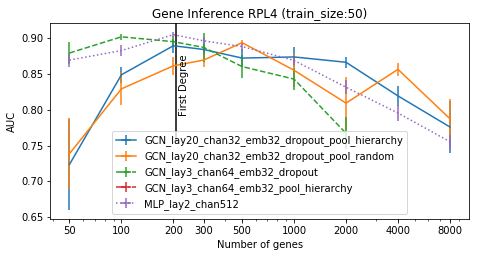

3


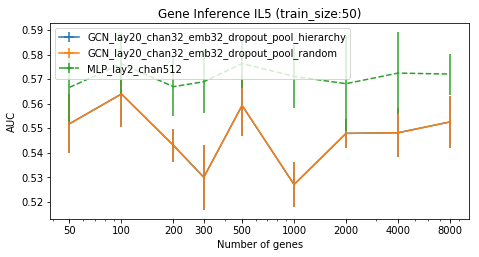

34


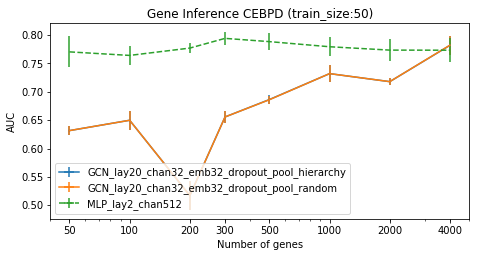

219


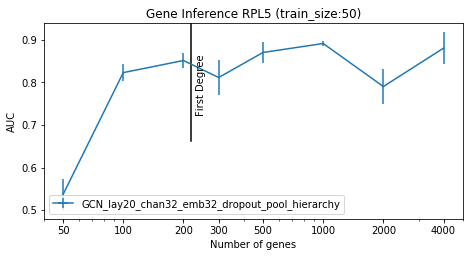

167


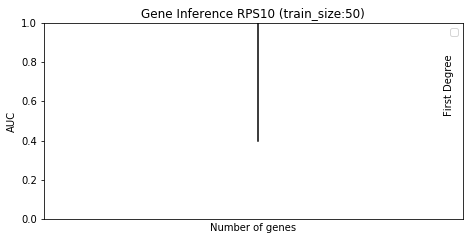

250


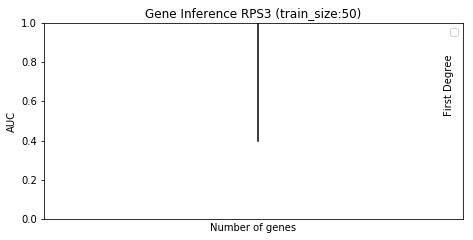

23


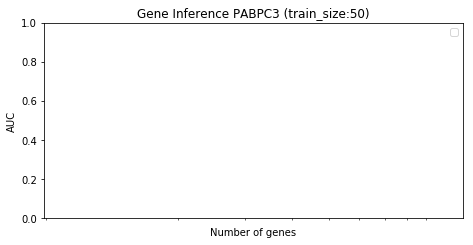

24


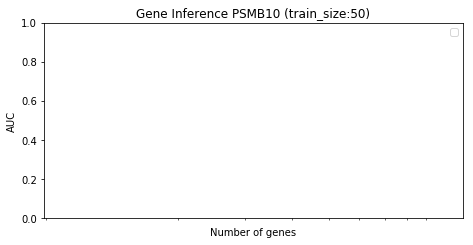

57


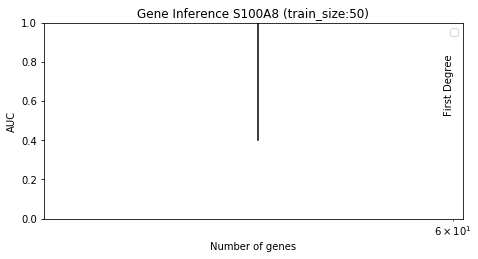

85


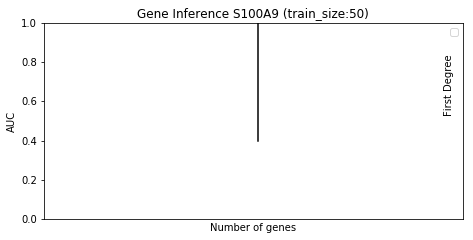

158


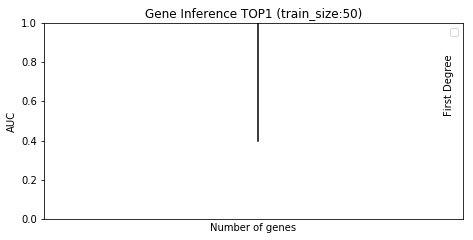

3


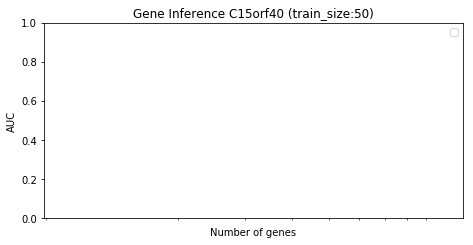

26


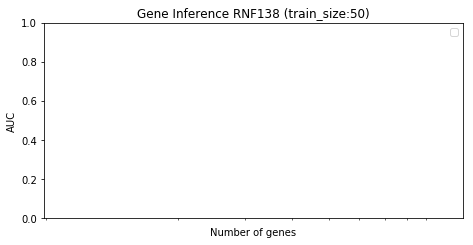

24


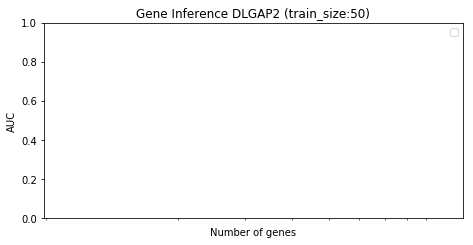

1


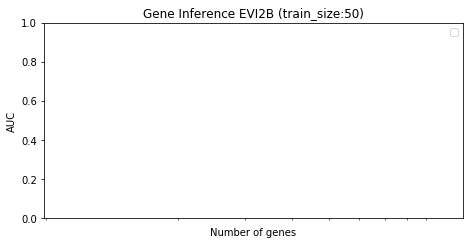

1


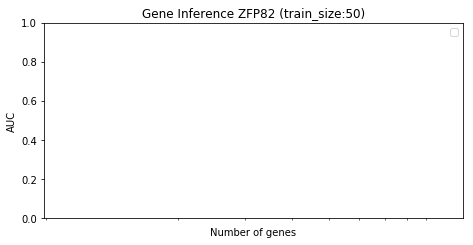

53


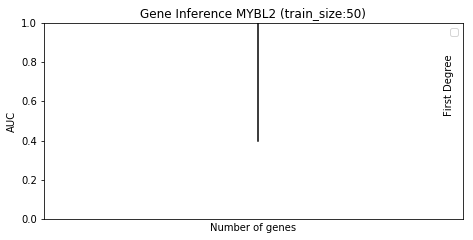

131


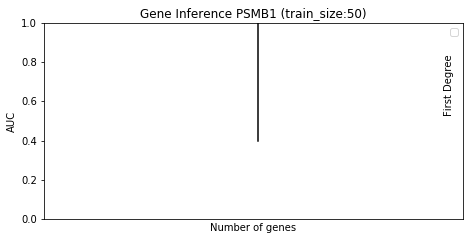

33


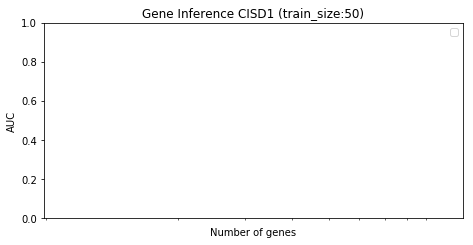

73


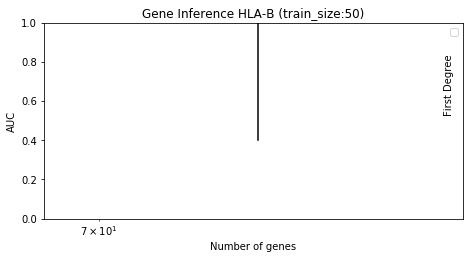

3


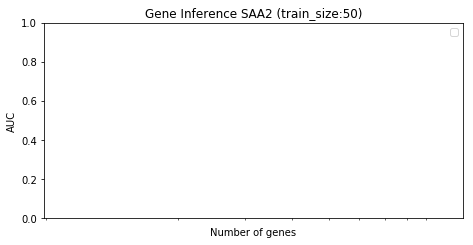

49


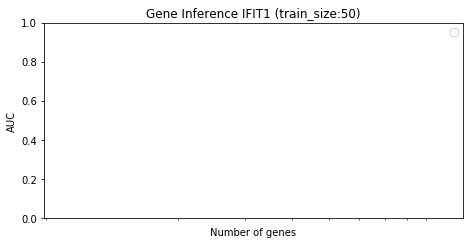

230


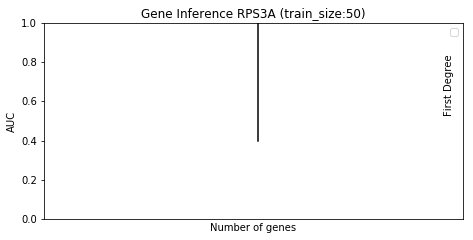

938


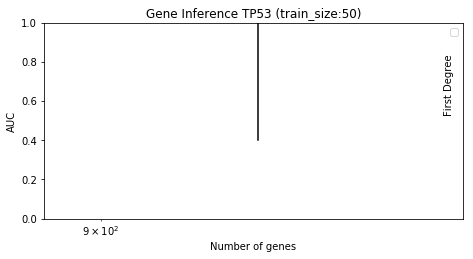

122


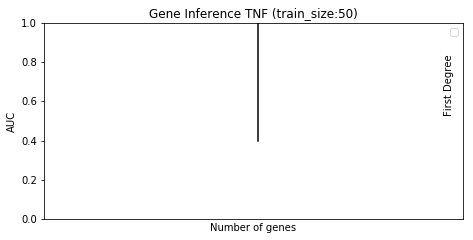

922


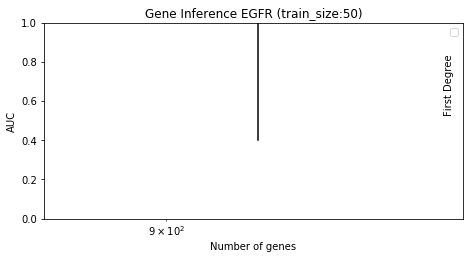

In [25]:

for plot_gene in search_genes:

    %matplotlib inline
    plt.rcParams['figure.figsize'] = (7.5, 3.6)
    plot_train_size = 50

    subset = results[(results.train_size==plot_train_size) & 
                      (results.gene==plot_gene) & 
                      (results.num_genes!=400) &      
                      (results.model != "GCN_lay3_chan64_emb32") & 
                      (results.model != "GCN_lay20_chan32_emb32_dropout_pool") & 
                      (results.model != "MLP_lay2_chan512_dropout") & 
                      (results.model != "SLR_lambda1_l11") & 
                      (results.num_genes> 0)]


    q = subset.groupby(['model','num_genes'])['auc']

    todo = list(subset["model"].unique())
    linestyles = ['-', '-', '--', '-.', ':']
    for ls, model in enumerate(sorted(todo)):
        index = list(q.mean()[model].index)
        mean = q.mean()[model]
        stderr = q.std()[model]/np.sqrt(q.count()[model])
        displayname = model.replace("CGN","GCN")
        displayname = displayname.replace("SLR", "SNLR")
        plt.errorbar(index, mean, label=displayname, xerr=0, yerr=stderr, ls=linestyles[ls])

    plt.title("Gene Inference " + plot_gene + " (train_size:" + str(plot_train_size) +")")
    plt.ylabel("AUC")
    plt.xlabel("Number of genes")
    plt.xscale("log")
    plt.xticks(sorted(subset["num_genes"].unique()))
    formatter = matplotlib.ticker.ScalarFormatter()
    plt.gca().xaxis.set_major_formatter(formatter)

    plt.legend();
    fd = len(list(gene_graph.nx_graph.neighbors(plot_gene)))
    print(fd)
    if fd > 50:
        plt.axvline(fd, ymin=0.4, ymax=1.0, c="black")
        c = plt.ylim()
        plt.text(fd*1.05,c[1]-((c[1]-c[0])*0.2),'First Degree',rotation=90)


    plt.savefig("experiments/results/sgi-" + plot_gene + "-" + "train" + str(plot_train_size) + ".png", bbox_inches='tight')
    plt.show()